In [3]:
import pandas as pd
import numpy as np
from meteostat import Point, Daily
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Fetching data using Meteostat
location = Point(37.7749, -122.4194)  # San Francisco
start = datetime(2010, 1, 1)
end = datetime(2020, 12, 31)

data = Daily(location, start, end)
data = data.fetch()

# Select the temperature column and drop missing values
data = data[['tavg']]
data = data.dropna()

# Reset index to use date as a column
data.reset_index(inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['tavg']])

# Function to create sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

# Define sequence length and create sequences
sequence_length = 50
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [4]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')



In [5]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0443 - val_loss: 0.0071
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0093 - val_loss: 0.0082
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0084 - val_loss: 0.0068
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0079 - val_loss: 0.0066
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0080 - val_loss: 0.0066
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0078 - val_loss: 0.0063
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0079 - val_loss: 0.0061
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0066 - val_loss: 0.0086
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0082 - val_loss: 0.0059
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0

In [8]:
# Make predictions
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

# Inverse transform the true values for comparison
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


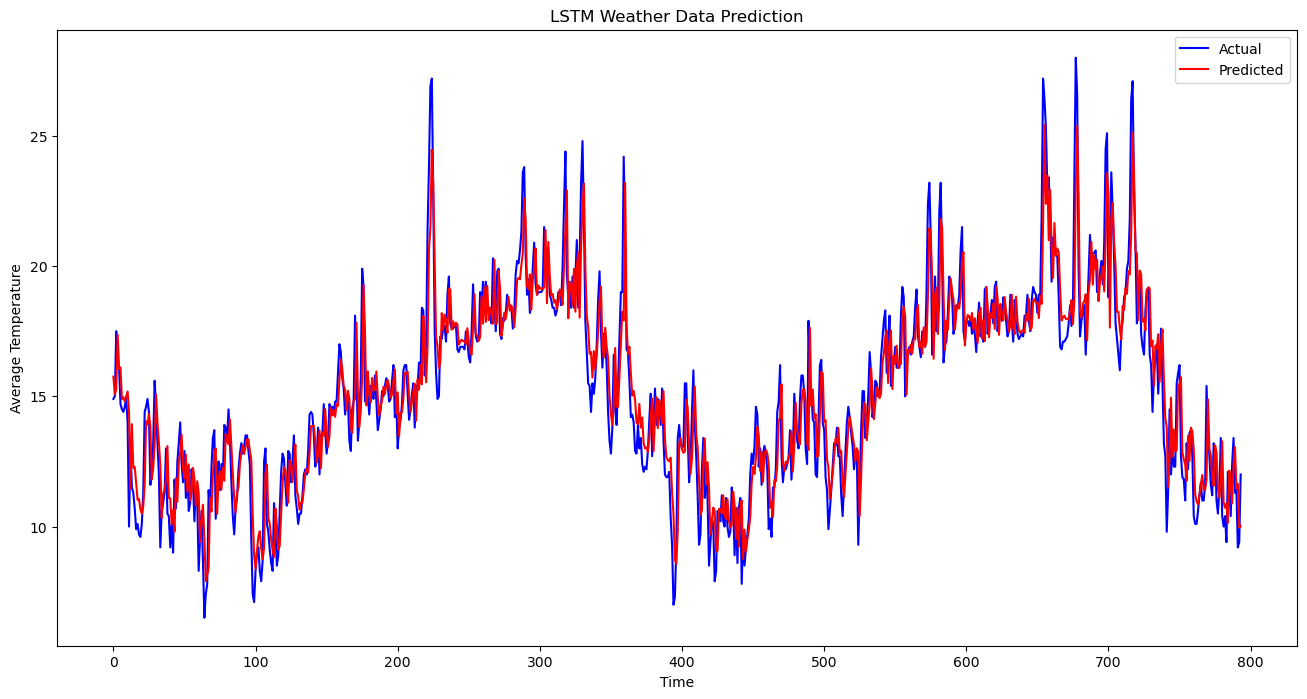

Mean Squared Error: 1.9884765867489576


In [9]:
# Evaluate the model
plt.figure(figsize=(16, 8))
plt.plot(range(len(y_test_actual)), y_test_actual, color='blue', label='Actual')
plt.plot(range(len(y_test_actual)), predicted, color='red', label='Predicted')
plt.title('LSTM Weather Data Prediction')
plt.xlabel('Time')
plt.ylabel('Average Temperature')
plt.legend()
plt.show()

# Calculate evaluation metrics (e.g., Mean Squared Error)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_actual, predicted)
print(f'Mean Squared Error: {mse}')
